Notes 
    
- Figure out categorical bayes problems
- Log loss entropy / class weighting
- problems with threshold graphs
- https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression

Questions for Leon
- Behavior of oversampling on logistic
- Performing naive bayes on other data
- why is XG boost stuck at a 0.5 AUC? How is accurac so high and precision / recall so low?
- Handling categorical with 150 types?

In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Importing Data

In [2]:
# import training data
path = 'raw Data/'
df_train = pd.read_csv(path + 'train.csv')
df_train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


In [3]:
# there are no null rows in the training data
null_data = df_train[df_train.isnull().any(axis=1)]
null_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response


In [4]:
## there are no duplicate ids in the training data
bool_series = df_train.duplicated() 
df_train[bool_series] 

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response


## EDA and Baselining

0    0.877437
1    0.122563
Name: Response, dtype: float64


<AxesSubplot:>

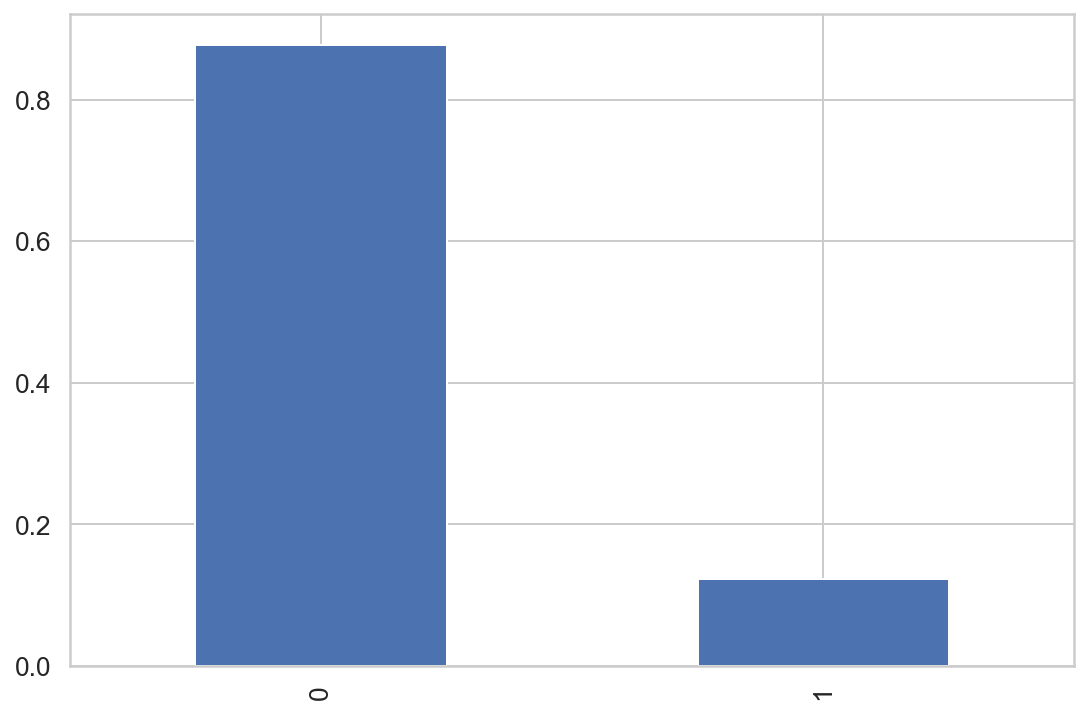

In [5]:
# check for distribution of the target
target_pcts = df_train.Response.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

In [6]:
def plot_features(df, sample_size=1000):
    # We don't need to plot the id (prod and user), and the latest cart is a list
    sample = df.drop(['id'], axis=1) \
                .sample(sample_size, random_state=44)

    g = sns.pairplot(sample, hue='Response', plot_kws=dict(alpha=.3, edgecolor='none'))

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


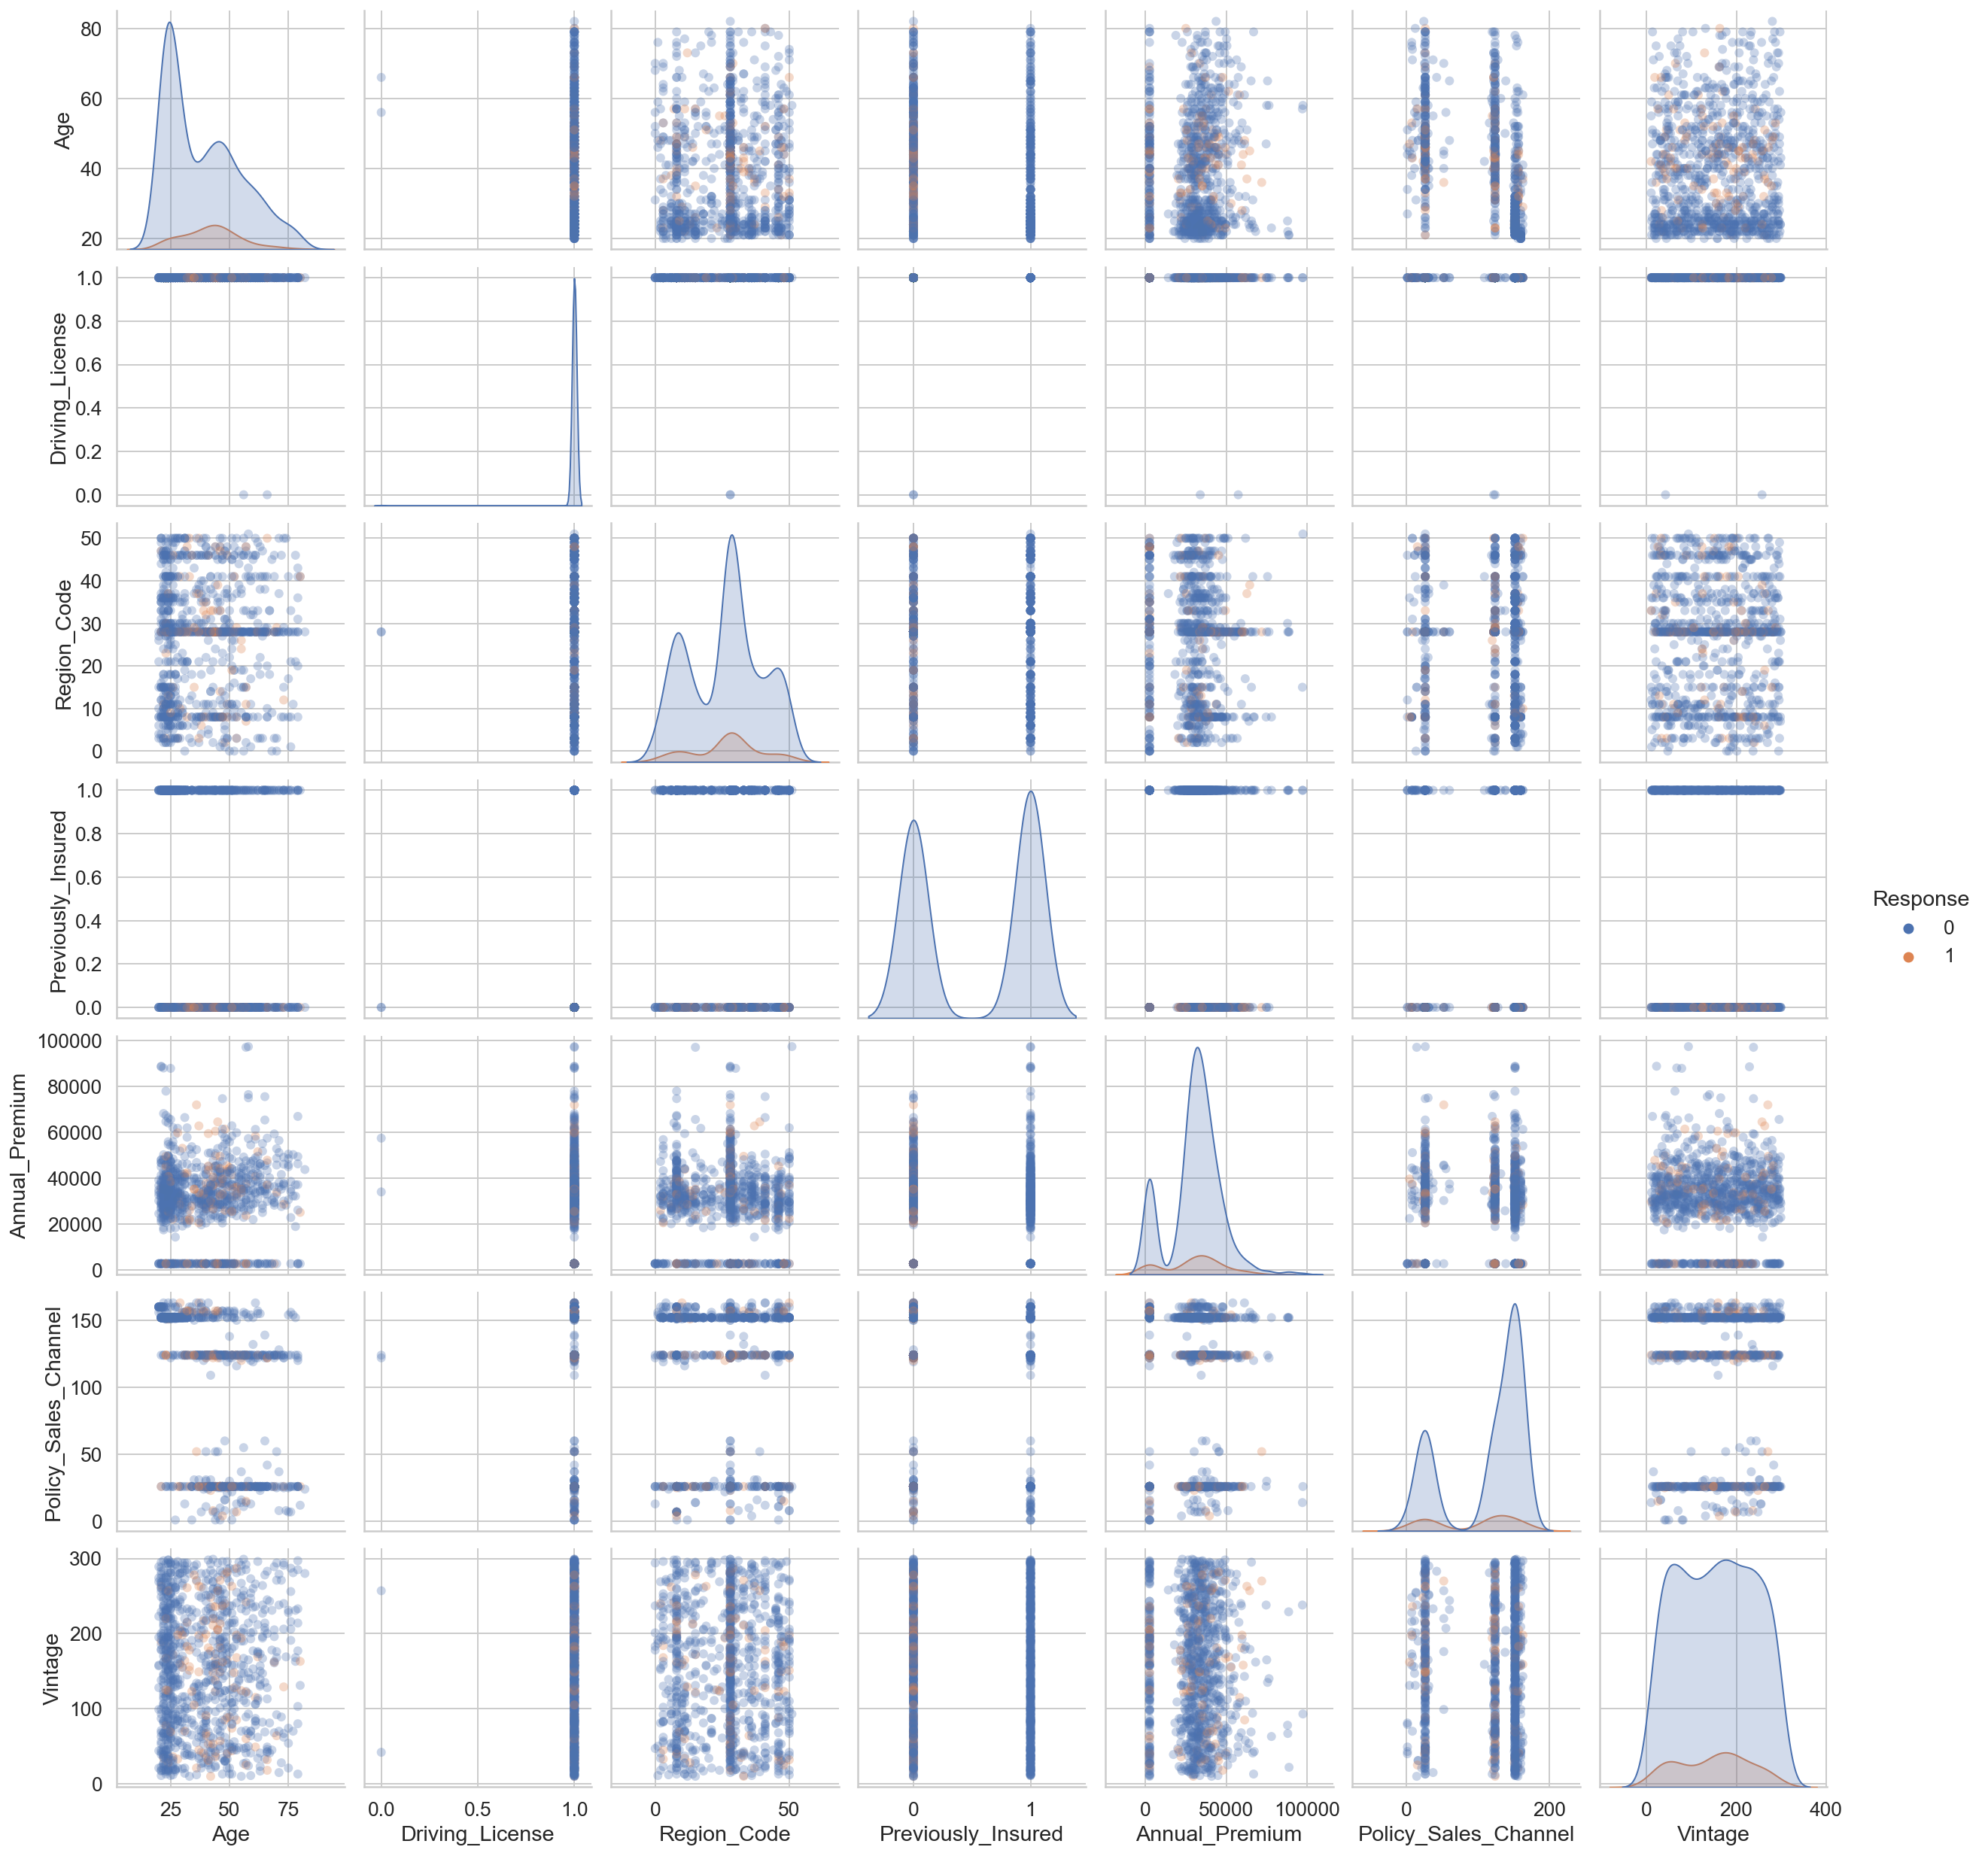

In [7]:
plot_features(df_train)

## 1) Basic Logistic

### Basic logistic regression on age, driving license, and previously insured.

In [8]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

In [9]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [10]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  87.74%
Val set score:  87.74%

Precision / Recall
Val F1 score:   0.00%
Precision: 0.0000,   Recall: 0.0000


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# analyze error with confusion matrix

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail to cross sell', 'cross sell'],
           yticklabels=['fail to cross sell', 'cross sell']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [13]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

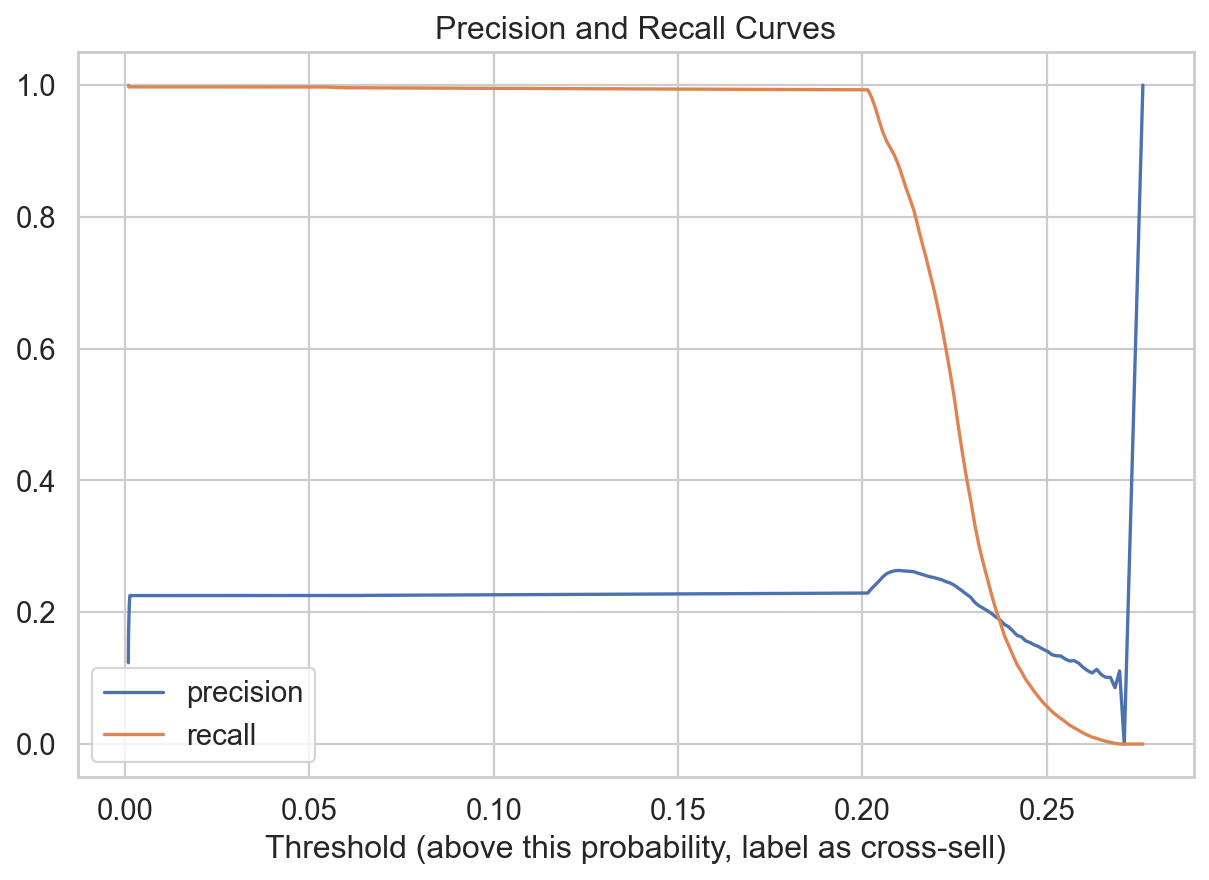

In [14]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [15]:
# let's test thresholds

In [16]:
# using the new threshold of 0.21
y_predict = (lr.predict_proba(X_val)[:,1] > 0.21)
print("Threshold of 0.21:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.21:
F1 Score : 0.4055, Precision: 0.2636,  Recall: 0.8793, 


### Basic logistic - All Features

In [17]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [18]:
X.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [19]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [20]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [21]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  87.73%
Val set score:  87.73%

Precision / Recall
Val F1 score:   0.01%
Precision: 0.4242,   Recall: 0.0030


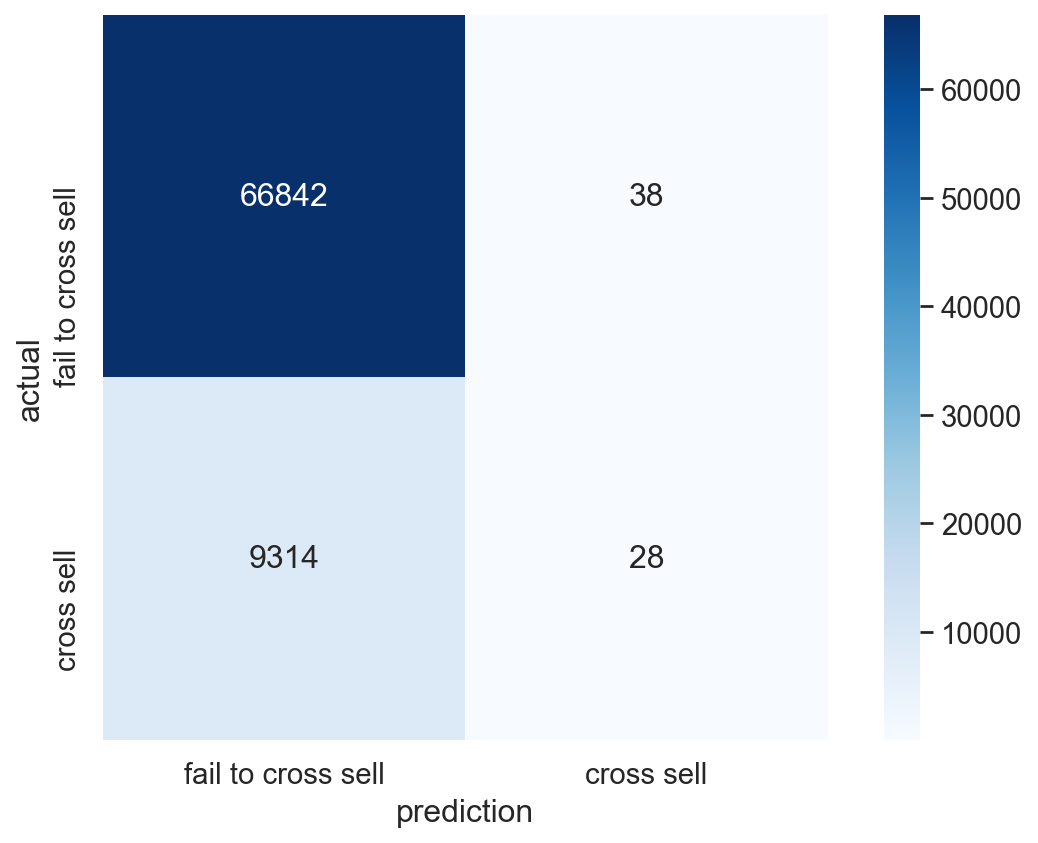

In [23]:
make_confusion_matrix(lr)

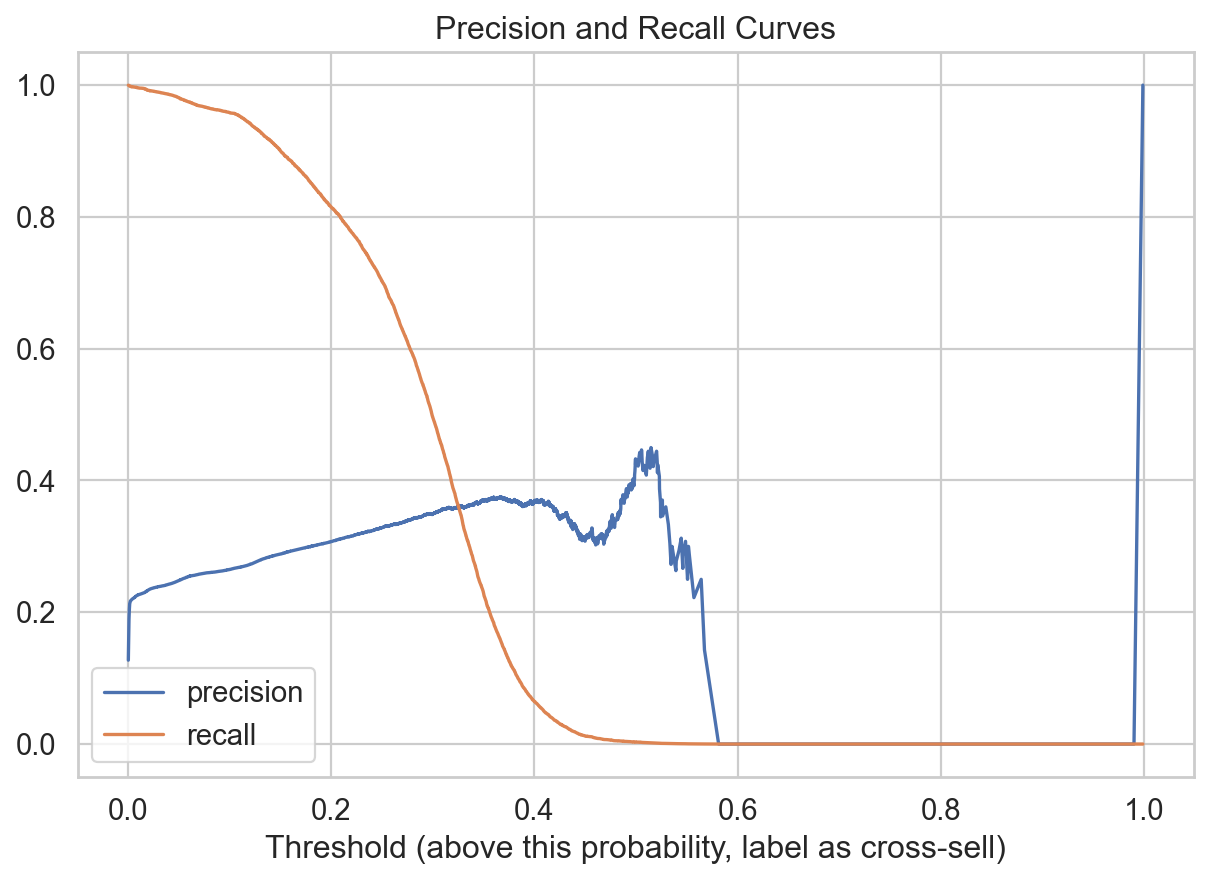

In [24]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [25]:
# using the new threshold of 0.23
y_predict = (lr.predict_proba(X_val)[:,1] > 0.23)
print("Threshold of 0.23:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.23:
F1 Score : 0.4495, Precision: 0.3199,  Recall: 0.7554, 


### Logistic All Featurs - Overamspling

#### 1) SMOTE

In [26]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [27]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [28]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [29]:
# Oversample training data
X_smoted_tr, y_smoted_tr = SMOTE(random_state=42).fit_sample(X_train,y_train)
Counter(y_smoted_tr)

Counter({0: 200639, 1: 200639})

In [30]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_smoted_tr)
X_val = scaler.transform(X_val)

In [31]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_smoted_tr, y_smoted_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_smoted_tr, y_smoted_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  58.13%
Val set score:  60.68%

Precision / Recall
Val F1 score:   0.30%
Precision: 0.1892,   Recall: 0.6719


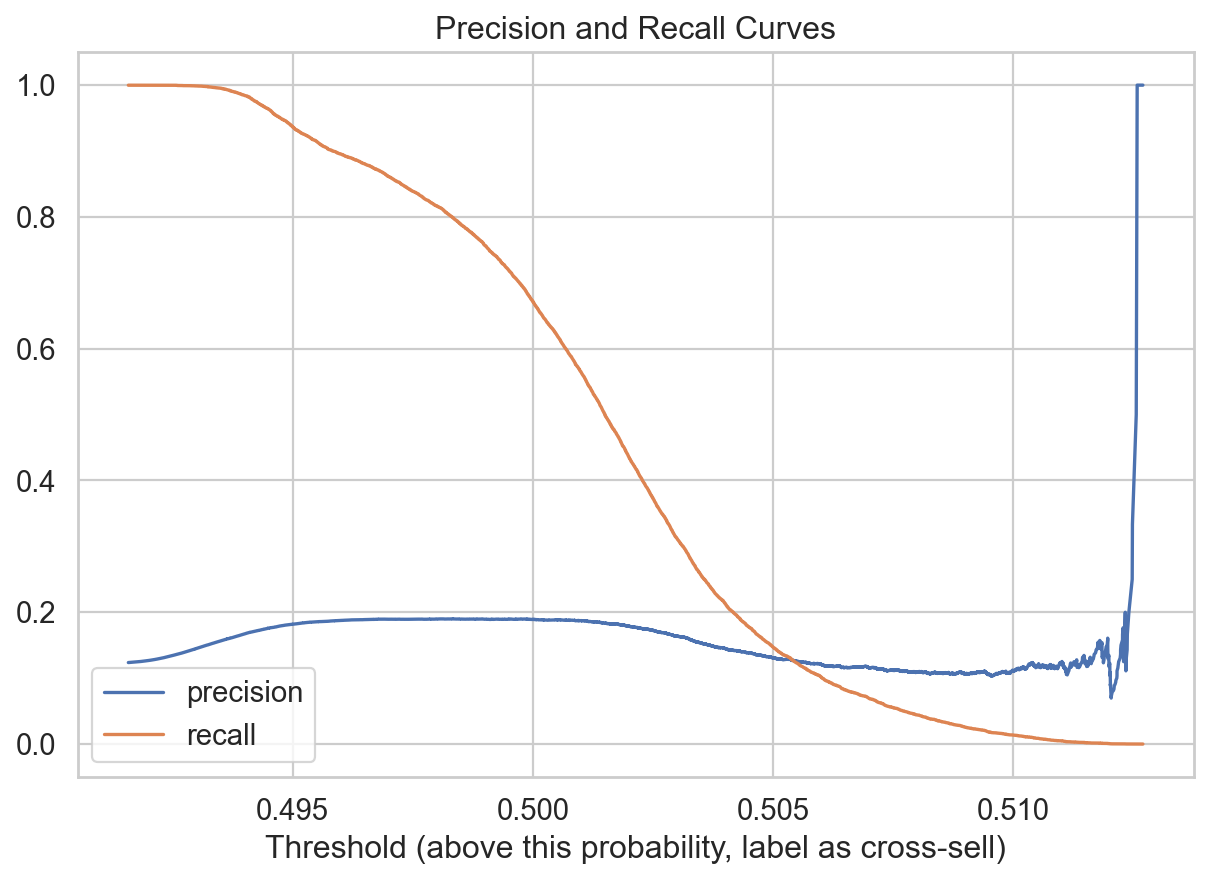

In [32]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

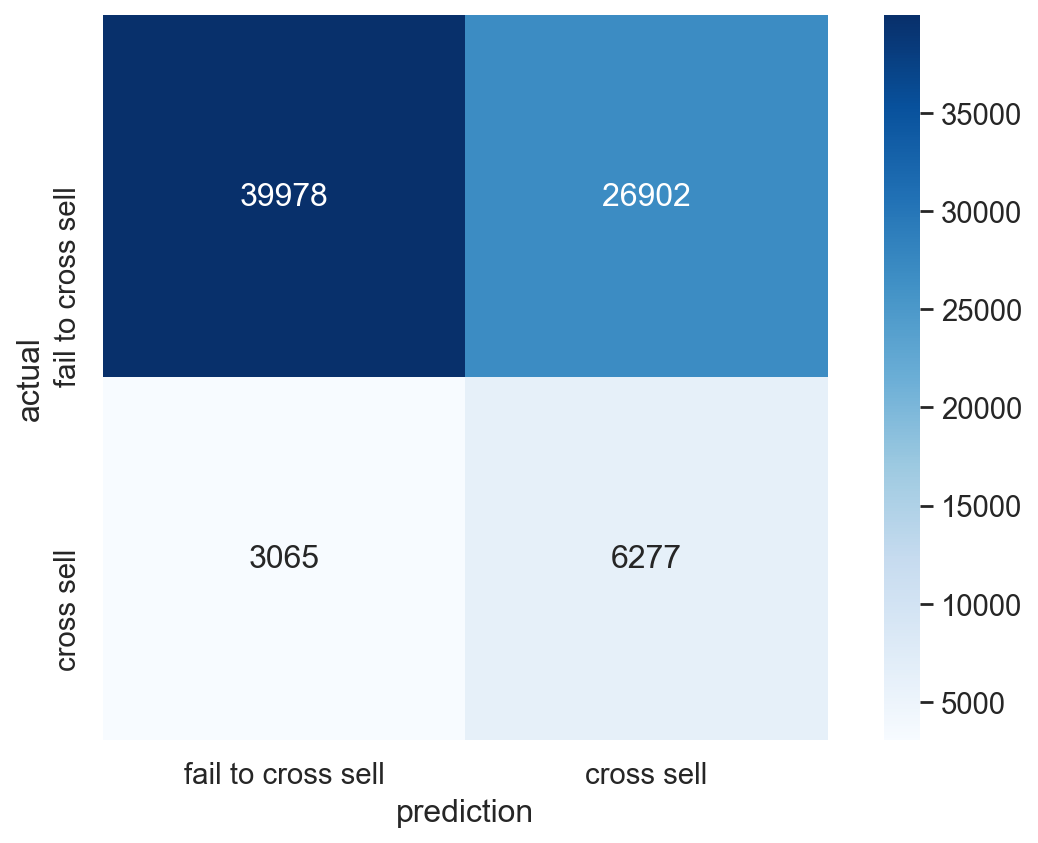

In [33]:
make_confusion_matrix(lr)

### 2) ADASYN

In [34]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [35]:
# Oversample training data
X_adasyn_tr, y_adasyn_tr = ADASYN(random_state=42).fit_sample(X_train,y_train)
Counter(y_adasyn_tr)

Counter({0: 200639, 1: 203604})

In [36]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_val = scaler.transform(X_val)

In [37]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_smoted_tr, y_smoted_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_adasyn_tr, y_adasyn_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  65.69%
Val set score:  60.89%

Precision / Recall
Val F1 score:   0.30%
Precision: 0.1909,   Recall: 0.6764


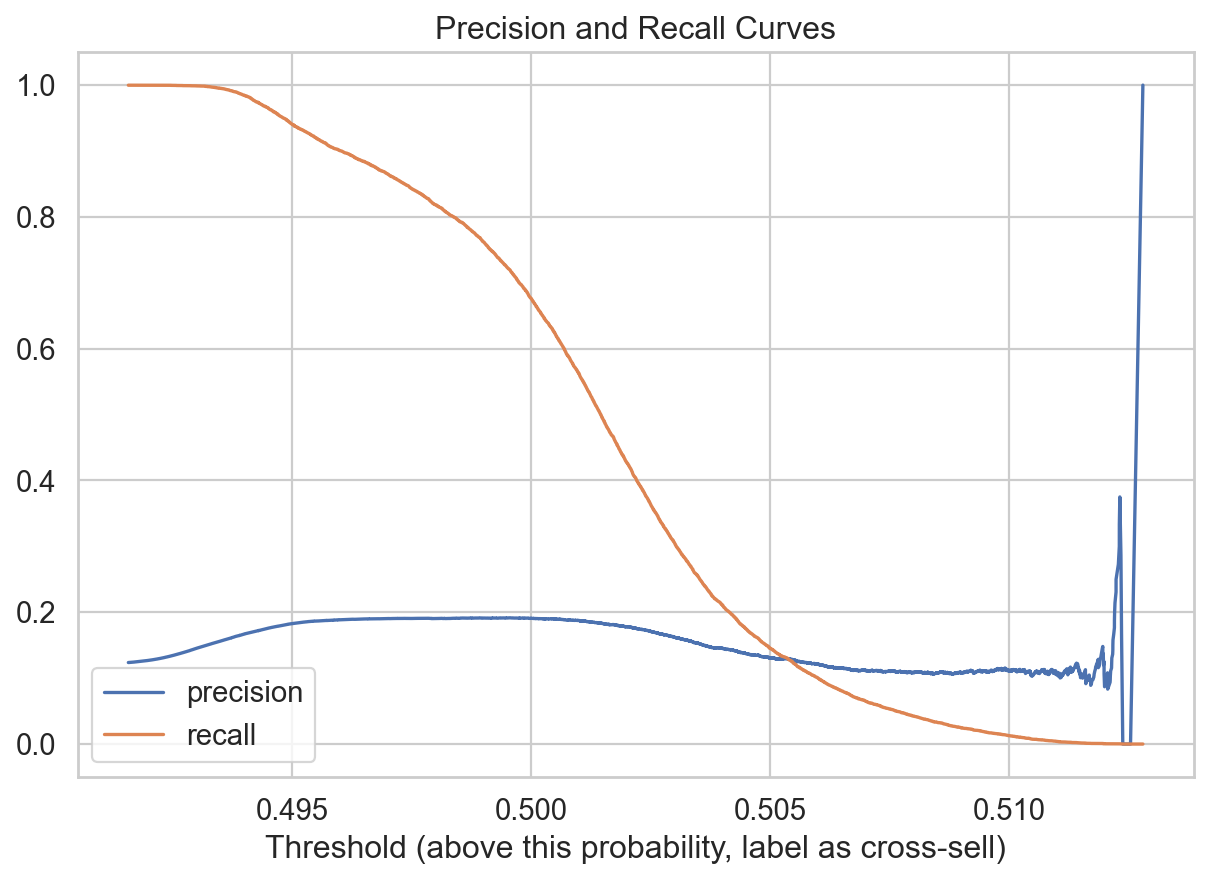

In [38]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [39]:
# using the new threshold of 0.23
y_predict = (lr.predict_proba(X_val)[:,1] > 0.01)
print("Threshold of 0.23:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.23:
F1 Score : 0.2184, Precision: 0.1226,  Recall: 1.0000, 


### 3) RandomOverSampler

In [40]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [41]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

Counter({0: 200639, 1: 200639})

In [42]:
# Scale features 
scaler = StandardScaler()
X_resampled_tr = scaler.fit_transform(X_resampled_tr)
X_val = scaler.transform(X_val)

In [43]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_resampled_tr, y_resampled_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  79.83%
Val set score:  69.42%

Precision / Recall
Val F1 score:   0.43%
Precision: 0.2772,   Recall: 0.9302


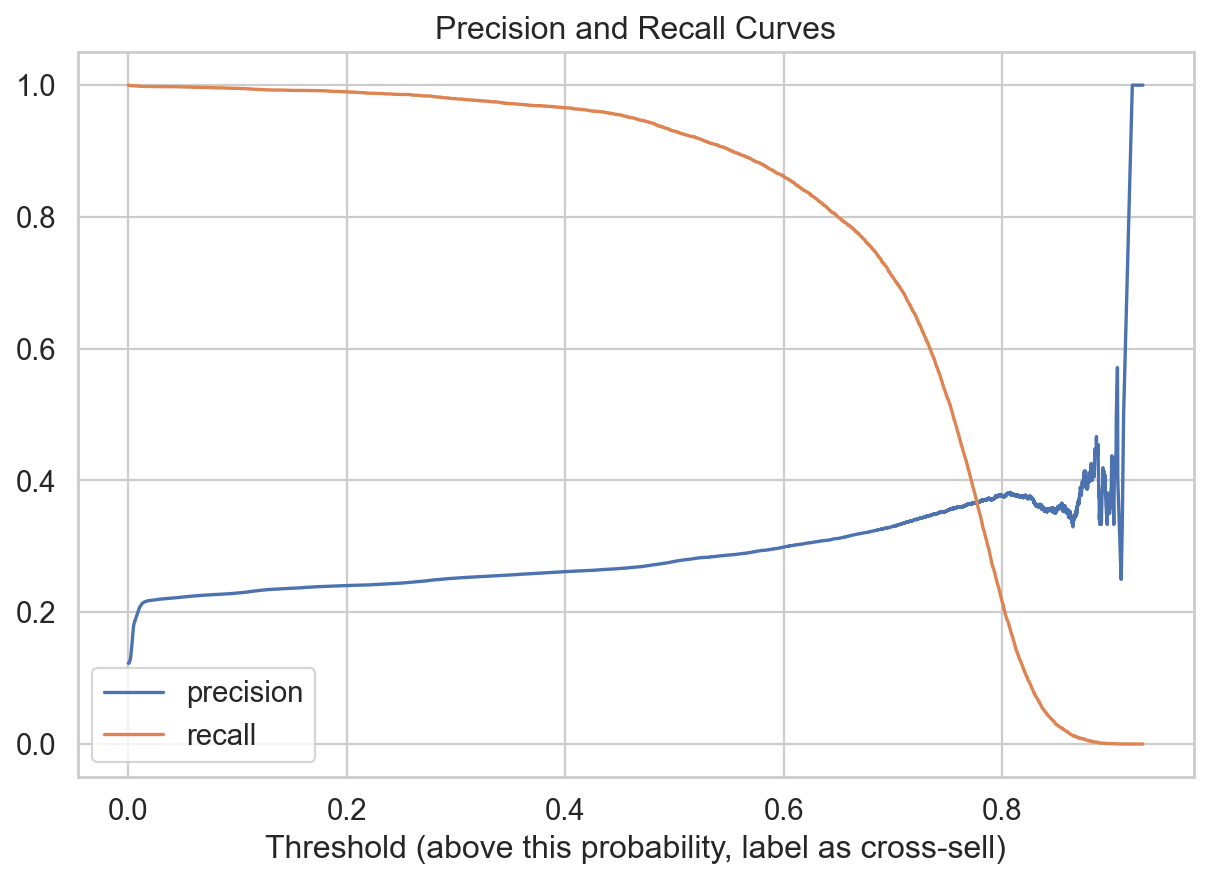

In [44]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [45]:
# using the new threshold 
y_predict = (lr.predict_proba(X_val)[:,1] > 0.67)
print("Threshold of 0.67:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.67:
F1 Score : 0.4519, Precision: 0.3195,  Recall: 0.7718, 


## 2) KNN

### Basic KNN on age, driving license, and previously insured.

In [106]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [107]:
# run initial KNN 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the knn
Training score:  84.38%
Val set score:  84.43%

Precision / Recall
Val F1 score:   0.22%
Precision: 0.2868,   Recall: 0.1820


In [108]:
# run KNN with fewer K
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the knn
Training score:  86.02%
Val set score:  86.17%

Precision / Recall
Val F1 score:   0.16%
Precision: 0.3132,   Recall: 0.1077


### Oversampling

In [109]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

In [110]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [111]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

Counter({1: 200639, 0: 200639})

In [112]:
# run initial KNN 
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_resampled_tr, y_resampled_tr)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the knn
Training score:  72.19%
Val set score:  73.16%

Precision / Recall
Val F1 score:   0.39%
Precision: 0.2725,   Recall: 0.7127


#### Use random grid search to optimize oversampled dataset

In [113]:
# specify "parameter distributions" rather than a "parameter grid"
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)

In [114]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [115]:
# n_iter controls the number of searches
#rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42)
#rand.fit(X_resampled_tr, y_resampled_tr)
#rand.cv_results_

In [116]:
# Pickle search results

#filename = "best_knn_model"
#pickle.dump(rand ,open(filename,'wb'))

In [117]:
# Load search results

#rand = pickle.load(open(filename,'rb'))

In [118]:
# examine the best model
#print(rand.best_score_)
#print(rand.best_params_)

In [119]:
# run best KNN 
knn = KNeighborsClassifier(n_neighbors=29,weights='distance')
knn.fit(X_resampled_tr, y_resampled_tr)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the knn
Training score:  74.92%
Val set score:  70.46%

Precision / Recall
Val F1 score:   0.40%
Precision: 0.2675,   Recall: 0.8115


## 3) Naive Bayes

### Start with Gaussian (continuous only)

In [120]:
# Seperate features from label

X = df_train.loc[:,['Age','Annual_Premium','Vintage']]

y = df_train['Response']

In [121]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [122]:
# Create Gaussian Model
nb = GaussianNB()
nb.fit(X_train, y_train)
# Score model
nb.score(X_val, y_val)

0.8770827320196268

In [123]:
# Further Metrics
y_predict = nb.predict(X_val)
#scores
print("Scores for the gaussian bayes")
print("Training score: {:6.2f}%".format(100*nb.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the gaussian bayes
Training score:  87.67%
Val set score:  87.71%

Precision / Recall
Val F1 score:   0.00%
Precision: 0.2632,   Recall: 0.0016


#### Apply over sampling 

In [124]:
# Over sample minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
Counter(y_resampled)

Counter({0: 200639, 1: 200639})

In [125]:
# Create Gaussian Model
nb = GaussianNB()
nb.fit(X_resampled, y_resampled)
# Score model
nb.score(X_val, y_val)

0.5903676104011965

In [126]:
# Further Metrics
y_predict = nb.predict(X_val)
#scores
print("Scores for the gaussian bayes")
print("Training score: {:6.2f}%".format(100*nb.score(X_resampled, y_resampled)))
print("Val set score: {:6.2f}%".format(100*nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the gaussian bayes
Training score:  64.67%
Val set score:  59.04%

Precision / Recall
Val F1 score:   0.31%
Precision: 0.1928,   Recall: 0.7353


### Categorical Features (can't get to work)

In [127]:
# Seperate features from label

X = df_train.loc[:,['Gender','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage']]

y = df_train['Response']

In [128]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage'],drop_first=True)

In [129]:
X

,Region_Code,Gender_Male,Previously_Insured_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,28.0,1,0,0,1,1
1,3.0,1,0,0,0,0
2,28.0,1,0,0,1,1
3,11.0,1,1,1,0,0
4,41.0,0,1,1,0,0
...,...,...,...,...,...,...
381104,26.0,1,1,0,0,0
381105,37.0,1,1,1,0,0
381106,30.0,1,1,1,0,0
381107,14.0,0,0,0,1,1


In [130]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [131]:
# Create Categorical NB Model
categorical_nb = CategoricalNB()
categorical_nb.fit(X_train, y_train)

CategoricalNB()

In [132]:
categorical_nb.score(X_val, y_val)

0.7849964577156202

In [133]:
X_val.shape

(76222, 6)

In [134]:
y_val.shape

(76222,)

In [135]:
X_train.shape

(228665, 6)

In [136]:
y_train.shape

(228665,)

## 4) Random Forest

### All variables

In [137]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [138]:
def gnumeric_func (data, columns):
  data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
  return data

In [139]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,0,44,1,0,0,0,0,40454.0,0,217
1,2,0,76,1,1,0,1,1,33536.0,0,183
2,3,0,47,1,0,0,0,0,38294.0,0,27
3,4,0,21,1,2,1,2,1,28619.0,1,203
4,5,1,29,1,3,1,2,1,27496.0,1,39
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,13,1,1,1,30170.0,0,88
381105,381106,0,30,1,20,1,2,1,40016.0,1,131
381106,381107,0,21,1,12,1,2,1,35118.0,2,161
381107,381108,1,68,1,42,0,0,0,44617.0,3,74


In [140]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [141]:
# run random forest
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_predict = clf.predict(X_val)

#scores
print("Scores for the clf")
print("Training score: {:6.2f}%".format(100*clf.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*clf.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(clf.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the clf
Training score: 100.00%
Val set score:  87.30%

Precision / Recall
Val F1 score:   0.13%
Precision: 0.4054,   Recall: 0.0782


### Apply oversampling

In [142]:
# Over sample minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
Counter(y_resampled)

Counter({1: 200639, 0: 200639})

In [143]:
# run random forest
clf = RandomForestClassifier()
clf.fit(X_resampled, y_resampled)
y_predict = clf.predict(X_val)

#scores
print("Scores for the clf")
print("Training score: {:6.2f}%".format(100*clf.score(X_resampled, y_resampled)))
print("Val set score: {:6.2f}%".format(100*clf.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(clf.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the clf
Training score: 100.00%
Val set score:  85.80%

Precision / Recall
Val F1 score:   0.28%
Precision: 0.3698,   Recall: 0.2251


## XG Boost

### Inital XG Boost

In [144]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [145]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,0,44,1,0,0,0,0,40454.0,0,217
1,2,0,76,1,1,0,1,1,33536.0,0,183
2,3,0,47,1,0,0,0,0,38294.0,0,27
3,4,0,21,1,2,1,2,1,28619.0,1,203
4,5,1,29,1,3,1,2,1,27496.0,1,39
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,13,1,1,1,30170.0,0,88
381105,381106,0,30,1,20,1,2,1,40016.0,1,131
381106,381107,0,21,1,12,1,2,1,35118.0,2,161
381107,381108,1,68,1,42,0,0,0,44617.0,3,74


In [146]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

#### Eval Metric: Error

In [147]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [148]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:   0.88%
F1 score:   0.00%
Precision score:   0.00%
Recall score:   0.00%
AUC:   0.50%


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Eval Metric: AUC

In [149]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [150]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:   0.88%
F1 score:   0.01%
Precision score:   0.66%
Recall score:   0.00%
AUC:   0.50%


#### Eval Metric: Precision

In [151]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='map', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
)

C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [152]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:   0.88%
F1 score:   0.01%
Precision score:   0.66%
Recall score:   0.00%
AUC:   0.50%


### Accounting for imbalanced data (directly changing the scale_pos_weight)

In [153]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [154]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,0,44,1,0,0,0,0,40454.0,0,217
1,2,0,76,1,1,0,1,1,33536.0,0,183
2,3,0,47,1,0,0,0,0,38294.0,0,27
3,4,0,21,1,2,1,2,1,28619.0,1,203
4,5,1,29,1,3,1,2,1,27496.0,1,39
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,13,1,1,1,30170.0,0,88
381105,381106,0,30,1,20,1,2,1,40016.0,1,131
381106,381107,0,21,1,12,1,2,1,35118.0,2,161
381107,381108,1,68,1,42,0,0,0,44617.0,3,74


In [155]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [156]:
# calculating small_pos_weight
# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.159


In [ ]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 10
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
)

In [ ]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

### Accounting for imbalanced data (grid search to change the scale_pos_weight)

In [159]:
# Define model classifier

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                       )

In [160]:
# define grid

weights = [1, 7.2, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
param_grid

{'scale_pos_weight': [1, 7.2, 10, 25, 50, 75, 99, 100, 1000]}

In [161]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [162]:
# define grid search
grid = GridSearchCV(estimator=gbm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [ ]:
# execute the grid search
#grid_result = grid.fit(X_train, y_train)

In [ ]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
#means = grid_result.cv_results_['mean_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, params):
#    print("%f (%f) with: %r" % (mean, param))

### Accounting for imbalanced data (oversampling)